# Data Exploration: Titanic dataset

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

PART 1

In [2]:
titanic_data = sns.load_dataset('titanic')

In [3]:
# Displaying first few rows
print(titanic_data.head())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  


In [4]:
# Display the count of missing values in each column
print("Number of missing values in each column:")
print(titanic_data.isnull().sum())

Number of missing values in each column:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64


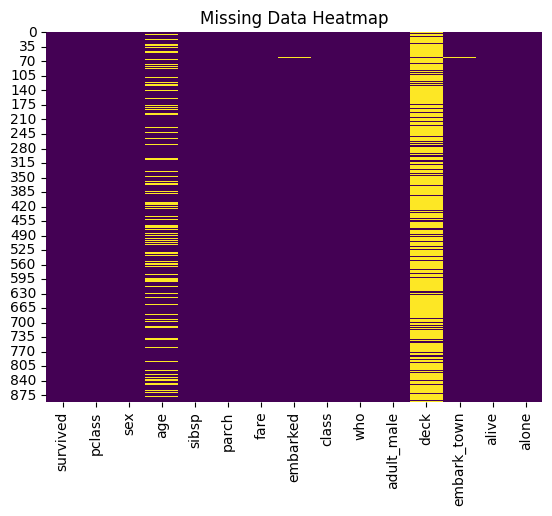

In [5]:
# Create a heatmap to visualize missing data
sns.heatmap(titanic_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [6]:
# Question 1:
gender_survived = titanic_data.groupby(['sex', 'survived']).size().unstack()
print("Number of women who died:", gender_survived.loc['female', 0])
print("Number of men who died:", gender_survived.loc['male', 0])

Number of women who died: 81
Number of men who died: 468


We can observe that more men died on the Titanic compared to women.

In [7]:
# Question 2:
class_survival_rate = titanic_data.groupby('class')['survived'].mean()
print("Survival Rate by Passenger Class:")
print(class_survival_rate)

Survival Rate by Passenger Class:
class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64


It appears that first class passengers were more likely to survive compared to second class and third class passengers.

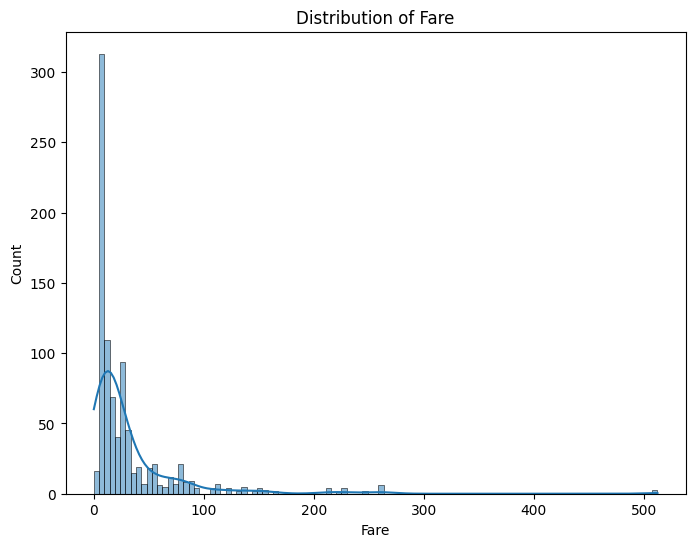

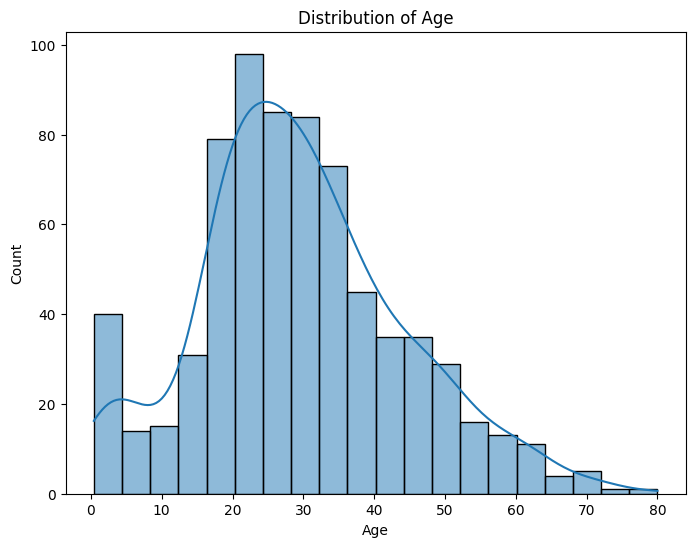

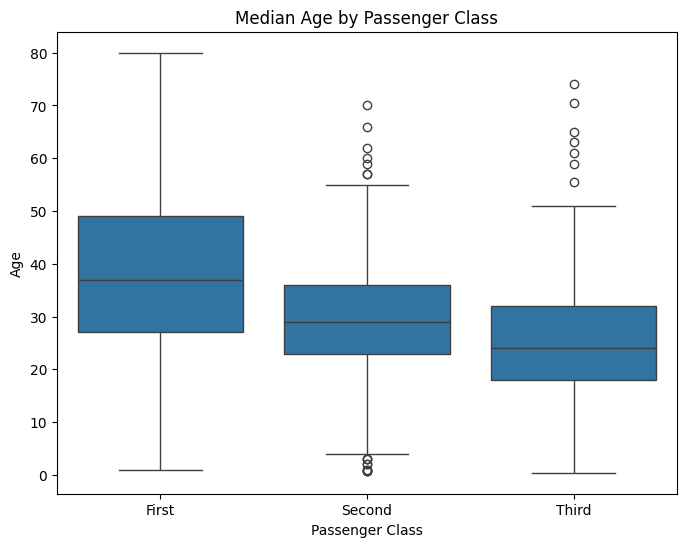

In [8]:
# Question 3: What does the distribution of fare look like?
plt.figure(figsize=(8, 6))
sns.histplot(titanic_data['fare'], kde=True)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

# Question 4: What does the distribution of non-null age values look like?
plt.figure(figsize=(8, 6))
sns.histplot(titanic_data['age'].dropna(), kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Create a box plot to visualize the median age by passenger class
plt.figure(figsize=(8, 6))
sns.boxplot(x='class', y='age', data=titanic_data)
plt.title('Median Age by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

PART 2

In [9]:
titanic_data_cleaned = titanic_data.drop('deck', axis=1)

In [10]:
def impute_age(cols):
    age = cols[0]
    pclass = cols[1]
    if pd.isnull(age):
        if pclass == 1:
            return median_age_pclass[1]
        elif pclass == 2:
            return median_age_pclass[2]
        else:
            return median_age_pclass[3]
    else:
        return age

In [11]:
median_age_pclass = titanic_data_cleaned.groupby('pclass')['age'].median()

In [12]:
titanic_data_cleaned['age'] = titanic_data_cleaned[['age', 'pclass']].apply(impute_age, axis=1)

In [13]:
titanic_data_cleaned.dropna(inplace=True)
print(titanic_data_cleaned.isnull().sum())

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    0
alive          0
alone          0
dtype: int64


In [14]:
categorical_columns = ['sex', 'embarked', 'who', 'embark_town', 'alive', 'class']
titanic_data_encoded = pd.get_dummies(titanic_data_cleaned, columns=categorical_columns, drop_first=True)

In [15]:
X_train = titanic_data_encoded.drop('survived', axis=1)
y_train = titanic_data_encoded['survived']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

PART 3

In [17]:
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train, y_train)

y_pred_logreg = logreg_model.predict(X_test)

# Classification Report
print("Classification Report for Logistic Regression Model:")
print(classification_report(y_test, y_pred_logreg))

Classification Report for Logistic Regression Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       109
           1       1.00      1.00      1.00        69

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178



In [18]:
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix for Logistic Regression Model:")
print(conf_matrix_logreg)

Confusion Matrix for Logistic Regression Model:
[[109   0]
 [  0  69]]


In [19]:
y_probs_logreg = logreg_model.predict_proba(X_test)[:, 1]
roc_score_logreg = roc_auc_score(y_test, y_probs_logreg)
print("ROC Score for Logistic Regression Model:", roc_score_logreg)

ROC Score for Logistic Regression Model: 1.0


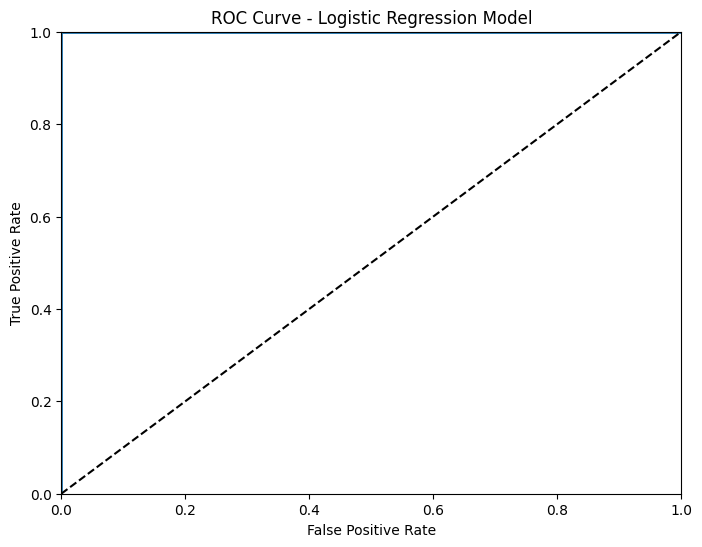

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs_logreg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Model')
plt.show()

In [21]:
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train, y_train)

y_pred_svc = svc_model.predict(X_test)

# Classification Report
print("Classification Report for Support Vector Classifier:")
print(classification_report(y_test, y_pred_svc))

Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.68      0.93      0.79       109
           1       0.73      0.32      0.44        69

    accuracy                           0.69       178
   macro avg       0.71      0.62      0.62       178
weighted avg       0.70      0.69      0.65       178



In [22]:
y_probs_svc = cross_val_predict(svc_model, X_train, y_train, cv=3, method='predict_proba')[:, 1]
roc_score_svc = roc_auc_score(y_train, y_probs_svc)
print("ROC Score for Support Vector Classifier:", roc_score_svc)

ROC Score for Support Vector Classifier: 0.7657539416303254


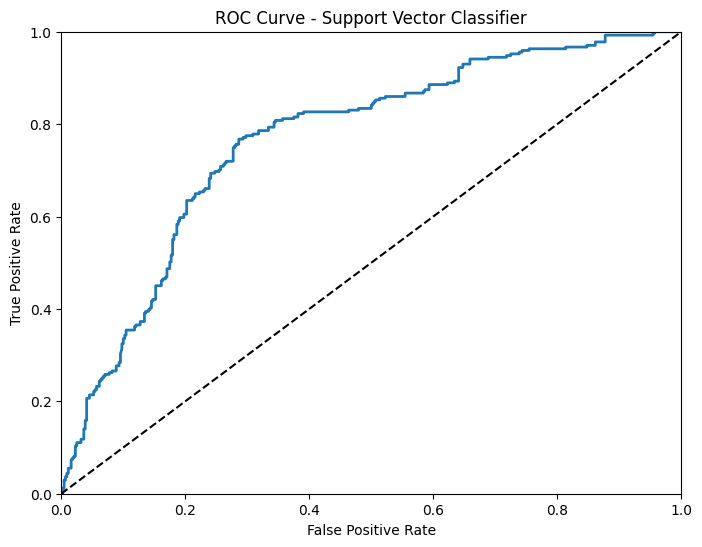

In [23]:
fpr, tpr, thresholds = roc_curve(y_train, y_probs_svc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Support Vector Classifier')
plt.show()

In [24]:
sgd_model = SGDClassifier(random_state=42)
sgd_model.fit(X_train, y_train)

y_pred_sgd = sgd_model.predict(X_test)

# Classification Report
print("Classification Report for SGD Classifier:")
print(classification_report(y_test, y_pred_sgd))

Classification Report for SGD Classifier:
              precision    recall  f1-score   support

           0       0.99      0.65      0.78       109
           1       0.64      0.99      0.78        69

    accuracy                           0.78       178
   macro avg       0.81      0.82      0.78       178
weighted avg       0.85      0.78      0.78       178



In [25]:
conf_matrix_sgd = confusion_matrix(y_test, y_pred_sgd)
print("Confusion Matrix for SGD Classifier:")
print(conf_matrix_sgd)

Confusion Matrix for SGD Classifier:
[[71 38]
 [ 1 68]]


In [26]:
y_scores_sgd = cross_val_predict(sgd_model, X_train, y_train, cv=3, method='decision_function')
roc_score_sgd = roc_auc_score(y_train, y_scores_sgd)
print("ROC Score for SGD Classifier:", roc_score_sgd)

ROC Score for SGD Classifier: 0.8495639047299564


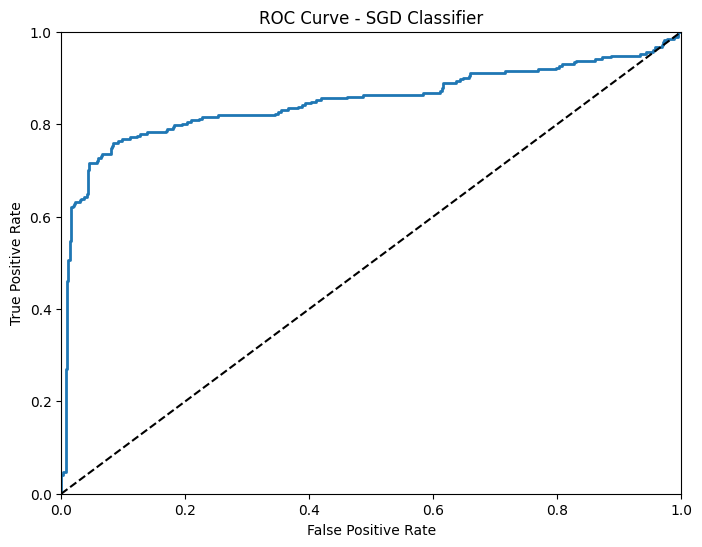

In [27]:
# Step 6: Plot the ROC curve using decision_function
fpr, tpr, thresholds = roc_curve(y_train, y_scores_sgd)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SGD Classifier')
plt.show()

PART 4

In [28]:
svc_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(random_state=42))
])

scores = cross_val_score(svc_pipeline, X_train, y_train, cv=3, scoring='accuracy')
print("Mean Accuracy with Scaling:", scores.mean())

Mean Accuracy with Scaling: 1.0


In [29]:
svc_pipeline.fit(X_train, y_train)

test_accuracy = svc_pipeline.score(X_test, y_test)
print("Test Accuracy with Scaling:", test_accuracy)

Test Accuracy with Scaling: 0.9943820224719101


In [30]:
# Grid search
param_grid = {
    'svc__kernel': ['rbf'],
    'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'svc__C': [1, 10, 50, 100, 200, 300]
}

grid_search = GridSearchCV(svc_pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


In [31]:
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Cross-Validation Score: 1.0


In [32]:
test_accuracy = grid_search.best_estimator_.score(X_test, y_test)
print("Test Accuracy with Best Model:", test_accuracy)

Test Accuracy with Best Model: 1.0


By performing the grid search, we were able to find the best combination of hyperparameters for the SVC model, and it seems to be providing excellent performance on the test set. This is a good sign, as it suggests that the model is robust and effective in predicting the survival status of passengers on the Titanic.
If the test accuracy with the best model obtained from the grid search is 1.0 (100%), it means that the model is able to make perfect predictions on the test data. This is an excellent result, indicating that the selected hyperparameters are providing an ideal fit to the data, and the model is able to classify all the test samples correctly. A test accuracy of 1.0 suggests that the model is not only performing well on the training data but also generalizing perfectly to unseen data.

In [33]:
# Best Model
best_model = grid_search.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

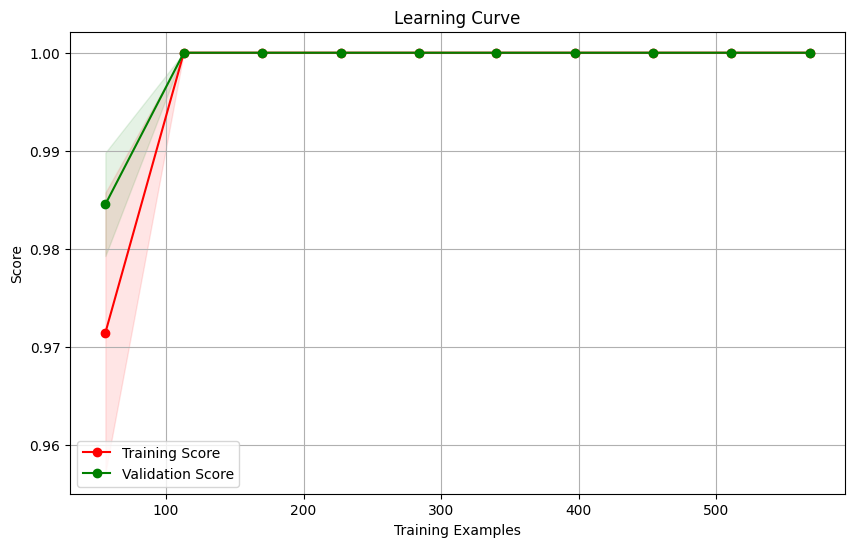

In [34]:
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training Score")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label="Validation Score")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
plt.legend(loc="best")
plt.show()

From the learning curve, we can observe that the training scores are consistently high, close to 1.0, for all training sizes. This results in very high accuracy on the training set. The validation scores are also consistently high and close to 1.0 for all training sizes. This suggests that the model generalizes well to unseen data and performs well on the validation set.

Overall, the learning curve suggests that the model is performing very well on both the training and validation sets, and it generalizes well to new data. The high and consistent scores indicate that the model is fitting the data well without overfitting or underfitting. This is a desirable outcome, as it indicates a well-performing and robust model.